In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('./../')

from collections import defaultdict

import torch
import tabulate
import numpy as np

import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

For the sake of simplicity, most of the additional functions were implemented in the `nb_utils` module.

# Load checkpoints

One can load an existing model using `nb_utils.load_checkpoint`. 

This function will return the Generator module (both trainee and ema-smoothed) as well as the initial Generator that corresponds to `--resume` CLI training option. Also, this function will parse and return the `training_options.json` and `metric-*.jsonl` files.

In [2]:
import nb_utils

In [7]:
device = torch.device('cuda:0')
base_exp_path = '~/StyleDomain/DissimilarDomains/training-runs'

## Obtain pretrained models

Pretrained checkpoints for this particular notebook can be found in the [file storage](https://nxt.2a2i.org/index.php/s/Q2MFXy6gpNnB4GF?path=%2F512). Download nessesary checkpoints (`"*-afhqdog-stylegan2-*"`) and put them into the `base_exp_path` folder.

In [8]:
exp_path = os.path.join(base_exp_path, '00066-afhqdog-stylegan2-kimg241-resumeffhq512')
(
    G, G_ema, # Trained Generator
    G_base, G_ema_base, # Resume Generator
    options, # Exact arguments that were used to train the model. See `training_options.json`
    metrics # Metrics that were computed during training and after it using `calc_metrics.py`
) = nb_utils.load_checkpoint(
    exp_path=exp_path, # Path to experiment folder
    chkpt_idx=241, # Checkpoint idx
    device=device # GPU or CPU device to store the module
)

In [9]:
print(*metrics.items(), sep='\n')

('fid50k', [(241, 18.870261049352113)])
('kid50k', [(241, 0.009100656791791829)])
('fid5k', [(0, 220.4657791514723), (20, 111.77333726801315), (40, 53.77089874308393), (60, 38.42584153866183), (80, 32.829910782598134), (100, 27.963927737224857), (120, 25.11018606367864), (140, 24.039953072029498), (160, 22.23814153985294), (180, 22.246368688383946), (200, 22.25561962207952), (220, 21.17775999610977), (240, 20.72892563890517), (241, 20.321961996440223), (241, 20.504168880221464)])
('kid5k', [(241, 0.008989224822322303)])


# Compute metrics

We can compute other metrics using `metric_main.calc_metric`. For example, here we compute $\text{FID5k}$ (aka $\text{FID}$) for the model finetuned on the **Dog** dataset with **Full** parameterization. It is worth noting that we also report $\text{FID} = 20.3$ in the paper.

In [10]:
from metrics import metric_main

/home/aalanov/mnakhodnov/Domain Adaptation/StyleDomain/DissimilarDomains/examples/./../metrics/metric_utils.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [12]:
metric = metric_main.calc_metric(
    metric='fid5k', G=G_ema, device=device,
    dataset_kwargs=options['training_set_kwargs']
)
print('{0} = {1:.3f}'.format(metric['metric'], metric['results'][metric['metric']]))

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
fid5k = 20.562


# Generate sample images

We can generate images from a pretrained model using the `nb_utils.generate_images` wrapper around Generator.

In [13]:
grid_size = np.array([4, 4])
images, _ = nb_utils.generate_images(G_ema, grid_size=grid_size, device=device)

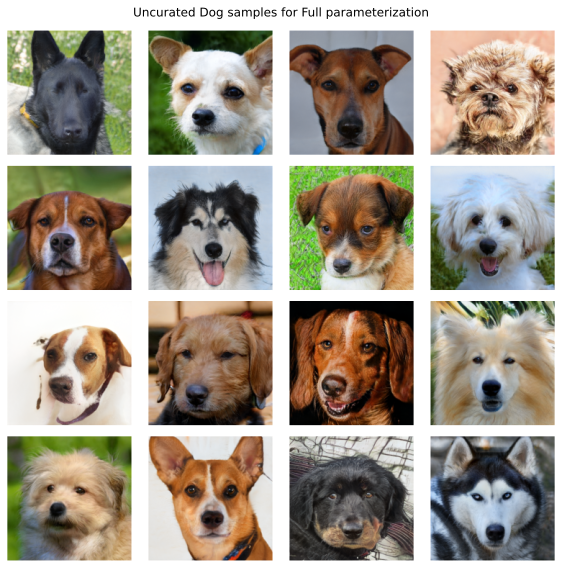

In [14]:
fig, axes = plt.subplots(*grid_size, figsize=grid_size[::-1] * 2)

nb_utils.prepare_axes(axes)
for ax, image in zip(axes.reshape(-1), images):
    ax.imshow(image)

fig.suptitle('Uncurated Dog samples for Full parameterization')
    
fig.subplots_adjust(wspace=0.01, hspace=0.01)
fig.tight_layout()
plt.show()

# Parameterization comparation

Let's compare $[\text{Full}, \text{SyntConv}, \text{Affine}+, \text{Affine}, \text{Mapping}, \text{AffineLight}+, \text{StyleSpace}]$ for Dog dataset.

Let's define a list of all those experiments:

In [16]:
afhqdog = {
    'Full':         '00066-afhqdog-stylegan2-kimg241-resumeffhq512',
    'Mapping':      '00066-afhqdog-stylegan2-kimg241-resumeffhq512-Gparts-mapping',
    'SyntConv':     '00315-afhqdog-stylegan2-kimg241-resumeffhq512-Gparts-synt_conv,tRGB_conv',
    'Affine':       '00068-afhqdog-stylegan2-kimg241-resumeffhq512-Gparts-synt_affine,tRGB_affine',
    'Affine+':      '00313-afhqdog-stylegan2-glrate0.02-kimg241-resumeffhq512-Gparts-synt_affine,tRGB_affine,synt_weights_offset.b64,tRGB_weights_offset.b64-use-dom-mod-out_in_additive',
    'StyleSpace':   '00147-afhqdog-stylegan2-glrate0.02-kimg241-resumeffhq512-Gparts-synt_offset,tRGB_offset-use-dom-mod-additive',
    'AffineLight+': '00253-afhqdog-stylegan2-glrate0.008-kimg241-resumeffhq512-Gparts-synt_affine_weights_offset,tRGB_affine_weights_offset,synt_weights_offset.b64,tRGB_weights_offset.b64-use-dom-mod-out_in_additive,affine_out_in_5_1_additive',
}

In [20]:
dog_models = dict()

for parameterization_name, exp_suffix in afhqdog.items():
    exp_path = os.path.join(base_exp_path, exp_suffix)
    
    _, G_ema, _, _, _, metrics = nb_utils.load_checkpoint(
        exp_path=exp_path, chkpt_idx=241, device=torch.device('cpu')
    )
    
    fid5k = dict(metrics['fid5k'])[241]
    kid5k = dict(metrics['kid5k'])[241]
    fid50k = dict(metrics['fid50k'])[241]
    kid50k = dict(metrics['kid50k'])[241]

    dog_models[parameterization_name] = (G_ema, (fid5k, kid5k, fid50k, kid50k))

Register weights offsets of shape: [512, 512, 1, 1], T: out_in_additive
Register weights offsets of shape: [512, 512, 1, 1], T: out_in_additive
Register weights offsets of shape: [3, 512, 1, 1], T: out_in_additive
Register domain modulation for b4.torgb. IN: 512, W: 512
Register domain modulation for b4.conv. IN: 512, W: 512
Register domain modulation for b8.torgb. IN: 512, W: 512
Register domain modulation for b8.torgb. IN: 512, W: 512
Register domain modulation for b8.conv. IN: 512, W: 512
Register domain modulation for b16.torgb. IN: 512, W: 512
Register domain modulation for b16.torgb. IN: 512, W: 512
Register domain modulation for b16.conv. IN: 512, W: 512
Register domain modulation for b32.torgb. IN: 512, W: 512
Register domain modulation for b32.torgb. IN: 512, W: 512
Register domain modulation for b32.conv. IN: 512, W: 512
Register domain modulation for b64.torgb. IN: 512, W: 512
Register domain modulation for b64.torgb. IN: 512, W: 512
Register domain modulation for b64.conv. 

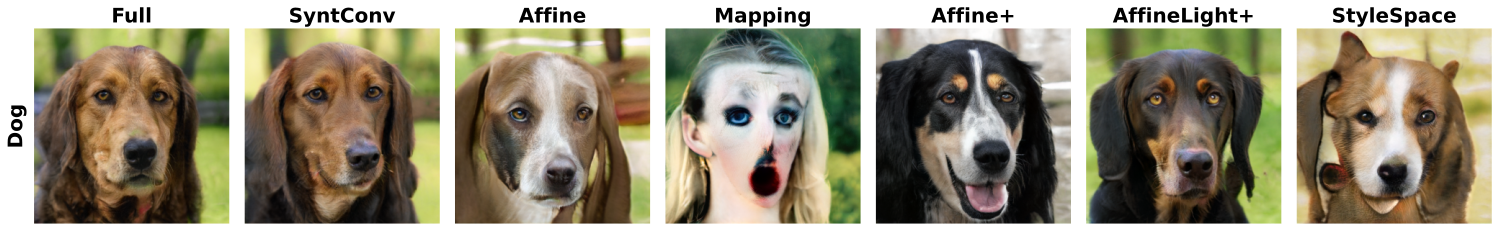

In [21]:
grid_size = np.array([1, 7])
fig, axes = plt.subplots(*grid_size, figsize=grid_size[::-1] * np.array([3, 3.2]))
nb_utils.prepare_axes(axes)

for idx, pname in enumerate(['Full', 'SyntConv', 'Affine', 'Mapping', 'Affine+', 'AffineLight+', 'StyleSpace']):
    G_ema, _ = dog_models[pname]
    images, _ = nb_utils.generate_images(G_ema, grid_size=1, device=device, seed=912, truncation_psi=0.9)
    
    axes[idx].imshow(images[0])
    axes[idx].set_title(pname, fontdict=dict(fontsize=20, weight='bold'))
axes[0].set_ylabel('Dog', fontdict=dict(fontsize=20, weight='bold'))
        
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.tight_layout()
plt.show()